In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!nvidia-smi

Sun Feb 23 09:40:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A5000               Off |   00000000:01:00.0 Off |                  Off |
| 30%   31C    P8             19W /  230W |     122MiB /  24564MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os

if 'notebooks' in os.getcwd():
    os.chdir("..")


from datasets import load_dataset, Dataset
from huggingface_hub import notebook_login
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import time
import csv
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer
import aiohttp
import asyncio
from tqdm.asyncio import tqdm
import torch
import scienceplots
plt.style.use(['science', 'no-latex'])

from src.text_utils import trim_text_to_token_limit

tqdm.pandas()

In [4]:
notebook_login()

In [5]:
torch.cuda.set_per_process_memory_fraction(0.6, device=0)


# Generating dataset

In this notebook we will sample our data for the training loop.

Given a dataset with texts and topics we take 1000 indexes randomly from each topic. Since we want our text to take into account the number of views and to have a diversified context length we apply the following probability distribution in the sampling process.

\begin{equation}
    \mathbb{P}(x_i \in \mathcal{D}) \propto \left(\text{number of views in }x_i \right) \times {(\text{number of words in } x_i) } 
\end{equation}

In [6]:
df = load_dataset("peulsilva/wikipedia-pt-topics2", cache_dir='/Data')['train']\
    .to_pandas()

In [7]:
df['num_words'] = df['text'].apply(lambda x: len(x.split(' ')))
all_df = []

candidate_labels = ["politica e negócios", "esporte", "ciência e tecnologia", "cultura e arte",  "geografia e historia"]

for topic in candidate_labels:
    df_topic = df.query(f"predicted_topic == '{topic}'")
    df_topic['weight'] = df_topic['num_views']
    idx_topic = np.random.choice(
        len(df_topic),
        p = df_topic['weight']/df_topic['weight'].sum(),
        size= 1_000,
        replace = False
    )

    df_samples = df_topic.iloc[idx_topic]
    df_samples['word_weighting'] = False
    all_df.append(df_samples)

for topic in candidate_labels:
    df_topic = df.query(f"predicted_topic == '{topic}'")
    df_topic['weight'] = df_topic['num_views'] * (df_topic['num_words'])
    idx_topic = np.random.choice(
        len(df_topic),
        p = df_topic['weight']/df_topic['weight'].sum(),
        size= 1_000,
        replace = False
    )
    df_samples = df_topic.iloc[idx_topic]
    df_samples['word_weighting'] = True
    all_df.append(df_samples)




/tmp/ipykernel_1039421/19148627.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_topic['weight'] = df_topic['num_views']
/tmp/ipykernel_1039421/19148627.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_samples['word_weighting'] = False
/tmp/ipykernel_1039421/19148627.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

Text(0.5, 0, 'Number of words')

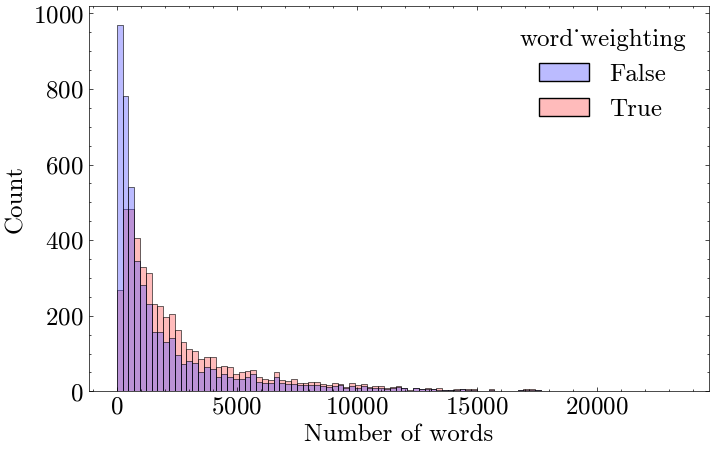

In [46]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize = (8,5))
sns.histplot(
    pd.concat(all_df, ignore_index= True),
    x = 'num_words',
    hue = 'word_weighting',
    alpha = 0.4,
    palette = 'seismic'
)

plt.xlabel("Number of words")


## Cutting text

Since we are limited on GPU memory, we have a limit of text size in our dataset. This limit is around 4000 tokens.

In [9]:
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct", cache_dir = '/Data')

In [10]:
sampled_df = pd.concat(all_df).query("word_weighting == True")
sampled_df.head()

,id,url,title,text,num_views,first_paragraph,predicted_topic,__index_level_0__,num_words,weight,word_weighting
4629,9513,https://pt.wikipedia.org/wiki/Conhecimento,Conhecimento,"Conhecimento (do latim cognoscere, ""ato de con...",129010.0,"Conhecimento (do latim cognoscere, ""ato de con...",politica e negócios,4656,2212,2.853701e+08,True
691,1337,https://pt.wikipedia.org/wiki/Nazismo,Nazismo,"O nazismo (), oficialmente nacional-socialismo...",467240.0,"O nazismo (), oficialmente nacional-socialismo...",politica e negócios,697,10530,4.920037e+09,True
901,1718,https://pt.wikipedia.org/wiki/Sergipe,Sergipe,Sergipe é uma das 27 unidades federativas do B...,314672.0,Sergipe é uma das 27 unidades federativas do B...,politica e negócios,908,5172,1.627484e+09,True
1465,3832,https://pt.wikipedia.org/wiki/Su%C3%AD%C3%A7a,Suíça,Suíça ( ; em suíço-alemão: Schwyz ou Schwiiz ;...,588196.0,Suíça ( ; em suíço-alemão: Schwyz ou Schwiiz ;...,politica e negócios,1475,9452,5.559629e+09,True
48,302,https://pt.wikipedia.org/wiki/Arist%C3%B3teles,Aristóteles,"Aristóteles (; Estagira, – Atenas, ) foi um f...",348607.0,"Aristóteles (; Estagira, – Atenas, ) foi um f...",politica e negócios,49,7075,2.466395e+09,True


In [11]:
def get_num_tokens(text, tokenizer):
    return len(tokenizer(text)['input_ids'])

sampled_df['num_tokens'] = sampled_df['text']\
    .progress_apply(get_num_tokens, tokenizer = tokenizer)

100%|██████████| 5000/5000 [00:41<00:00, 120.03it/s]


<Axes: xlabel='num_tokens', ylabel='Count'>

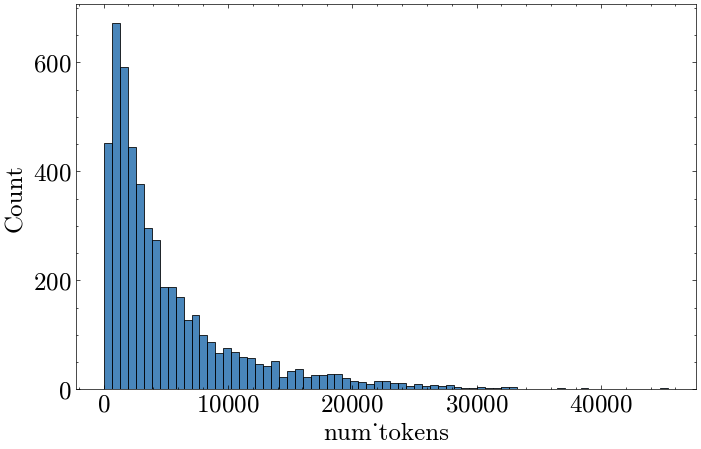

In [12]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize = (8,5))
sns.histplot(sampled_df['num_tokens'])

In [28]:
sampled_df['new_text'] = sampled_df['text']\
    .progress_apply(
        trim_text_to_token_limit,
        tokenizer = tokenizer
    )

100%|██████████| 5000/5000 [00:19<00:00, 250.81it/s]


In [29]:
sampled_df

,id,url,title,text,num_views,first_paragraph,predicted_topic,__index_level_0__,num_words,weight,word_weighting,num_tokens,new_text
4629,9513,https://pt.wikipedia.org/wiki/Conhecimento,Conhecimento,"Conhecimento (do latim cognoscere, ""ato de con...",129010.0,"Conhecimento (do latim cognoscere, ""ato de con...",politica e negócios,4656,2212,2.853701e+08,True,4010,"Conhecimento (do latim cognoscere, ""ato de con..."
691,1337,https://pt.wikipedia.org/wiki/Nazismo,Nazismo,"O nazismo (), oficialmente nacional-socialismo...",467240.0,"O nazismo (), oficialmente nacional-socialismo...",politica e negócios,697,10530,4.920037e+09,True,19394,"O nazismo (), oficialmente nacional-socialismo..."
901,1718,https://pt.wikipedia.org/wiki/Sergipe,Sergipe,Sergipe é uma das 27 unidades federativas do B...,314672.0,Sergipe é uma das 27 unidades federativas do B...,politica e negócios,908,5172,1.627484e+09,True,9891,Sergipe é uma das 27 unidades federativas do B...
1465,3832,https://pt.wikipedia.org/wiki/Su%C3%AD%C3%A7a,Suíça,Suíça ( ; em suíço-alemão: Schwyz ou Schwiiz ;...,588196.0,Suíça ( ; em suíço-alemão: Schwyz ou Schwiiz ;...,politica e negócios,1475,9452,5.559629e+09,True,17521,Suíça ( ; em suíço-alemão: Schwyz ou Schwiiz ;...
48,302,https://pt.wikipedia.org/wiki/Arist%C3%B3teles,Aristóteles,"Aristóteles (; Estagira, – Atenas, ) foi um f...",348607.0,"Aristóteles (; Estagira, – Atenas, ) foi um f...",politica e negócios,49,7075,2.466395e+09,True,12841,"Aristóteles (; Estagira, – Atenas, ) foi um f..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4079,8371,https://pt.wikipedia.org/wiki/A%20Portuguesa,A Portuguesa,"A Portuguesa, que hoje é um dos símbolos nacio...",73926.0,"A Portuguesa, que hoje é um dos símbolos nacio...",geografia e historia,4105,1089,8.050541e+07,True,2265,"A Portuguesa, que hoje é um dos símbolos nacio..."
2669,6142,https://pt.wikipedia.org/wiki/Arouca,Arouca,Arouca é uma vila da Área Metropolitana do Por...,50575.0,Arouca é uma vila da Área Metropolitana do Por...,geografia e historia,2691,4803,2.429117e+08,True,9122,Arouca é uma vila da Área Metropolitana do Por...
18606,466465,https://pt.wikipedia.org/wiki/Rodrigo%20da%20F...,Rodrigo da Fonseca Magalhães,"Rodrigo da Fonseca Magalhães (Condeixa-a-Nova,...",2797.0,"Rodrigo da Fonseca Magalhães (Condeixa-a-Nova,...",geografia e historia,151110,3850,1.076845e+07,True,7178,"Rodrigo da Fonseca Magalhães (Condeixa-a-Nova,..."
12889,165327,https://pt.wikipedia.org/wiki/XviD,XviD,XviD é um software livre e codec de vídeo MPEG...,154654.0,XviD é um software livre e codec de vídeo MPEG...,geografia e historia,75133,525,8.119335e+07,True,900,XviD é um software livre e codec de vídeo MPEG...


In [30]:
num_tokens_new_text = sampled_df['new_text'].progress_apply(get_num_tokens, tokenizer = tokenizer)

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:12<00:00, 410.30it/s]


Text(0.5, 0, 'Number of tokens')

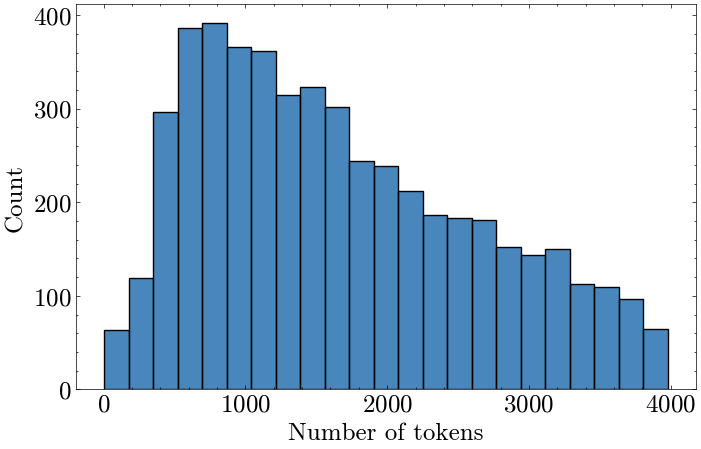

In [32]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize = (8,5))
sns.histplot(num_tokens_new_text)

plt.xlabel("Number of tokens")

In [34]:
sampled_df['num_new_tokens'] = num_tokens_new_text

In [37]:
sampled_df = sampled_df.rename(columns={
    'text': 'base_text',
    'new_text':'text',
    'num_tokens': 'num_tokens_base_text',
    'num_new_tokens': 'num_tokens',
})
sampled_df.to_json("data/wikipedia_dataset.json")

In [45]:
print(sampled_df.sample(n = 1)['text'].item())

Amazonas é uma das 27 unidades federativas do Brasil. Está situado na Região Norte, sendo o maior estado do país em extensão territorial, com uma área de , constituindo-se na nona maior subdivisão mundial, sendo maior que as áreas da França, Espanha, Suécia e Grécia somadas. Seria o décimo sexto maior país do mundo em área territorial, pouco superior à Mongólia. É maior que a região Nordeste, e maior que as regiões Sul e Sudeste juntas, e equivale a 2,25 vezes a área do estado norte-americano do Texas. A área média de seus 62 municípios é de , superior à área do estado brasileiro de Sergipe. O maior de seus municípios em extensão territorial é Barcelos, com  e o menor é Iranduba, com . Localiza-se no território amazonense o Pico da Neblina, ponto mais alto do Brasil, com  metros de altitude. Sua capital é o município de Manaus e seu atual governador é Wilson Lima.

Com mais de 4,2 milhões de habitantes ou cerca de 2% da população brasileira, é o segundo estado mais populoso da Região N